### Setup

In [349]:
# Set this to point to the pythonpath-appropriate location of rvspecfit
# or set to None to ignore:
# rvspecfit_path = None
rvspecfit_path = "/global/u1/a/apcooper/software/rvspecfit/lib/python3.8/site-packages/rvspecfit-0.1.0.210117+dev-py3.8.egg"

# Then execute following cells

In [350]:
import os
import sys
import glob
import numpy as np
import scipy 

import warnings

from astropy.table import Table
from astropy.io import fits

from desitarget.targetmask import mws_mask, bgs_mask, desi_mask, scnd_mask

from IPython.display import Image
from IPython.core.display import HTML 

import matplotlib.pyplot as pl
%matplotlib inline

viewer_url_template = "https://www.legacysurvey.org/viewer-desi?ra={ra}&dec={dec}&layer=ls-dr9&zoom=16"
cutout_url_template = "https://www.legacysurvey.org/viewer-desi/cutout.jpg?ra={ra}&dec={dec}&layer=ls-dr9&pixscale=0.13"

In [351]:
if rvspecfit_path is not None:
    if not rvspecfit_path in sys.path:
        sys.path.append(rvspecfit_path)
    import rvspecfit
    from rvspecfit.desi import desi_fit

In [352]:
def do_fit(d):
    """
    """
    config_fname = './config_210117.yaml'
    config = rvspecfit.utils.read_config(config_fname)
    options = {'npoly': 10}

    pixlim = dict()
    pixlim['b'] = (41,3731)
    pixlim['r'] = (490,3762)
    pixlim['z'] = (167,3975)

    for x in 'brz':
        clip = np.arange(pixlim[x][0],pixlim[x][1])

        waves[x] = np.array(d[x.upper()]['WAVELENGTH'][clip]) # Note different dim to others
        fluxes[x] = np.array([d[x.upper()]['FLUX'][clip]])
        ivars[x] = np.array([d[x.upper()]['IVAR'][clip]])

        # Have to hack the mask a bit, maybe this gets done in redrock
        # and isn't in the quicklook spectrum
        mask = d[x.upper()]['MASK'][clip]
        mask[ivars[x][0]<=0] = 1
        masks[x] = np.array([mask])

    setups = ['b', 'r', 'z']
    
    specdata = desi_fit.get_specdata(waves,fluxes,ivars,masks,0,False,setups)
    outdict,yfit = desi_fit.proc_onespec(specdata, setups, config, options, doplot=False)
    
    return specdata, outdict, yfit

In [353]:
def make_plot(specdata, params, yfit):
    """
    Copied directly almost directly from rvspecfit, without the savefig,
    and taking the fit result directly.
    """
    import matplotlib.pyplot as plt
    
    title = ('logg=%.1f teff=%.1f [Fe/H]=%.1f ' +
             '[alpha/Fe]=%.1f Vrad=%.1f+/-%.1f') % (
                 params['LOGG'], params['TEFF'].value,
                 params['FEH'],  params['ALPHAFE'], params['VRAD'].value,
                 params['VRAD_ERR'].value)
    
    
    alpha = 0.8
    line_width = 0.8
    dpi = 150
    plt.clf()
    ndat = len(specdata)
    figsize = (8, 3 * ndat)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    for i in range(ndat):
        fig.add_subplot(ndat, 1, i + 1)
        curspec = specdata[i].spec
        perc = 0.2
        xind = specdata[i].badmask
        ymin, ymax = [
            scipy.stats.scoreatpercentile(curspec[~xind], _)
            for _ in [perc, 100 - perc]
        ]
        plt.plot(specdata[i].lam, specdata[i].spec, 'k-', linewidth=line_width)
        plt.plot(specdata[i].lam[xind],
                 specdata[i].spec[xind],
                 'b.',
                 linewidth=line_width)
        plt.fill_between(specdata[i].lam,
                         specdata[i].spec - specdata[i].espec,
                         specdata[i].spec + specdata[i].espec,
                         color='grey',
                         alpha=0.1,
                         zorder=10)
        plt.plot(specdata[i].lam[xind],
                 specdata[i].spec[xind],
                 'b.',
                 linewidth=line_width)
        plt.plot(specdata[i].lam,
                 yfit[i],
                 'r-',
                 alpha=alpha,
                 linewidth=line_width)
        plt.ylim(ymin, ymax)
        
        if i == 0:
            plt.title(title)
            
        if i == ndat - 1:
            plt.xlabel(r'$\lambda$ [$\AA$]')
    plt.tight_layout()
    return

In [354]:
def get_fa(night,expid):
    """
    """
    fa_glob = "/global/cfs/cdirs/desi/spectro/data/{night:d}/{expid:08d}/fiberassign-*.fits.gz".format(night=int(night),
                                                                                                       expid=int(expid))
    fa_files = glob.glob(fa_glob)
    assert(len(fa_files) == 1)
    fa_fn = fa_files[0]
        
    return Table.read(fa_fn,'FIBERASSIGN')

In [355]:
def find_mws_fibers(night,expid,mws_class=None,brighter_than_gaiamag=None):
    """
    """
    fa = get_fa(night,expid)

    is_mws = fa['MWS_TARGET'] > 0
    
    if mws_class is not None:
        is_mws &= ((fa['MWS_TARGET'] & mws_mask[mws_class]) != 0)
        
    if brighter_than_gaiamag is not None:
        is_mws &= fa['GAIA_PHOT_G_MEAN_MAG'] > 0 
        is_mws &= fa['GAIA_PHOT_G_MEAN_MAG'] < brighter_than_gaiamag
    return np.flatnonzero(is_mws)

In [356]:
def gather_data(night,expid,fiber):
    """
    """
    fa = get_fa(night,expid)
    
    nightwatch_dir = "/global/cfs/cdirs/desi/spectro/nightwatch/kpno/{night:d}/{expid:08d}".format(night=int(night),
                                                                                                   expid=int(expid))
        
    coordinates_fn = os.path.join(nightwatch_dir,"coordinates-{expid:08d}.fits".format(expid=int(expid)))
    coordinates = Table.read(coordinates_fn)
    fa_fiber = np.asarray(coordinates['FA_FIBER'],dtype=np.int32)
    
    idx = np.flatnonzero(fa_fiber == fiber)
    petal = coordinates['PETAL_LOC'][idx][0]
    ifib  = FIBER - 500*petal

    retdict = dict()
    retdict['FA'] = fa
    
    target = fa[fa['FIBER'] == fiber][0]
    retdict['TARGET'] = target
    retdict['RA'] = np.float32(target['TARGET_RA'])
    retdict['DEC'] = np.float32(target['TARGET_DEC'])

    retdict['B'] = dict()
    retdict['R'] = dict()
    retdict['Z'] = dict()

    for _ in 'BRZ':
        fn = os.path.join(nightwatch_dir,"qcframe-{arm}{petal:d}-{expid:08d}.fits".format(
            arm=_.lower(), petal=int(petal), expid=int(expid)))
        retdict[_]['WAVELENGTH'] = fits.getdata(fn,extname="WAVELENGTH")[ifib]
        retdict[_]['FLUX'] = fits.getdata(fn,extname="FLUX")[ifib]
        retdict[_]['IVAR'] = fits.getdata(fn,extname="IVAR")[ifib]
        retdict[_]['MASK'] = fits.getdata(fn,extname="MASK")[ifib]
        
    retdict['viewer_url'] = viewer_url_template.format(ra = retdict['RA'], dec = retdict['DEC'])
    retdict['cutout_url'] = cutout_url_template.format(ra = retdict['RA'], dec = retdict['DEC'])
    
    return retdict

In [357]:
def summary(d):
    """
    """
    t = d['TARGET']
    fa = d['FA']
    
    g = 22.5 - np.log10(t['FLUX_G'])
    r = 22.5 - np.log10(t['FLUX_R'])
    z = 22.5 - np.log10(t['FLUX_Z'])
    
    print(d['viewer_url'])
    print()
    print('TARGETID: {}'.format(t['TARGETID']))
    print(d['RA'],d['DEC'])
    print('Gaia G mag:',t['GAIA_PHOT_G_MEAN_MAG'])
    print('g,r,z, g-r: {:4.2f},  {:4.2f},  {:4.2f}, {:4.2f}'.format(g,r,z, g-r))
    print()
    if t['DESI_TARGET'] > 0:
        desi_names = desi_mask.names(t['DESI_TARGET'])
        print('DESI:', desi_names)
    if t['MWS_TARGET'] > 0:
        mws_names = mws_mask.names(t['MWS_TARGET'])
        print('MWS: ', mws_names)
    if t['BGS_TARGET'] > 0:
        bgs_names = bgs_mask.names(t['BGS_TARGET'])
        print('BGS :', bgs_names)
    if t['SCND_TARGET'] > 0:
        scnd_names = scnd_mask.names(t['SCND_TARGET'])
        print('SNCD:', scnd_names)          
    print()
    display(t)
    print()

    display(Image(url=d['cutout_url']))
    
    med_flux = np.median(np.concatenate([d['B']['FLUX'],d['R']['FLUX'],d['Z']['FLUX']]))
    mad = np.median(np.concatenate([np.abs(d['B']['FLUX']-med_flux),
                                    np.abs(d['R']['FLUX']-med_flux),
                                    np.abs(d['Z']['FLUX']-med_flux)]))
    
    NSAMPLE = 10
        
    pl.figure(figsize=(15,4))
    pl.plot(d['B']['WAVELENGTH'][::NSAMPLE],d['B']['FLUX'][::NSAMPLE],c='b',lw=0.5)
    pl.plot(d['R']['WAVELENGTH'][::NSAMPLE],d['R']['FLUX'][::NSAMPLE],c='r',lw=0.5)
    pl.plot(d['Z']['WAVELENGTH'][::NSAMPLE],d['Z']['FLUX'][::NSAMPLE],c='g',lw=0.5)
    pl.grid()
    pl.axhline(med_flux,c='k',ls='--',zorder=-10)

    NSAMPLE = 1
    perc = 0.1
    
    def _plot(w,f,ivar,c='k',nsample=1,perc=0.1):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            mask = ~np.isfinite(1.0/ivar)
        pl.plot(w[::nsample],f[::nsample],c=c,lw=0.5)
        ymin, ymax = [scipy.stats.scoreatpercentile(f[~mask], _) for _ in [perc, 100 - perc]]
        pl.ylim(ymin,ymax)  
        pl.grid()
    
    pl.figure(figsize=(15,6))
    pl.subplot(3,1,1)
    _plot(d['B']['WAVELENGTH'],d['B']['FLUX'],d['B']['IVAR'],c='b')
    
    pl.subplot(3,1,2)
    _plot(d['R']['WAVELENGTH'],d['R']['FLUX'],d['R']['IVAR'],c='r')
    
    pl.subplot(3,1,3)
    _plot(d['Z']['WAVELENGTH'],d['Z']['FLUX'],d['Z']['IVAR'],c='g')

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        g_all = 22.5 - np.log10(fa['FLUX_G'])
        r_all = 22.5 - np.log10(fa['FLUX_R'])
        z_all = 22.5 - np.log10(fa['FLUX_Z'])

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        pl.figure(figsize=(6,6))
        pl.hexbin(g_all-r_all,r_all-z_all,bins='log',gridsize=100)
        pl.scatter(g-r,r-z,s=20,c='r')
        pl.xlabel('g-r')
        pl.ylabel('r-z')
        pl.grid()
    return d

### Working

In [336]:
NIGHT = 20210604
EXPID = 91169

In [361]:
# Can search for spectra of a given class or minimum magnitude
mws_fibs = find_mws_fibers(NIGHT,EXPID,mws_class='MWS_MAIN_RED',brighter_than_gaiamag=17)
print(len(mws_fibs),mws_fibs[0])

1 2460


https://www.legacysurvey.org/viewer-desi?ra=203.15577697753906&dec=8.905362129211426&layer=ls-dr9&zoom=16

TARGETID: 39628004833364801
203.15578 8.905362
Gaia G mag: 16.92895
g,r,z, g-r: 20.61,  20.23,  20.07, 0.38

DESI: ['MWS_ANY']
MWS:  ['MWS_MAIN_RED', 'MWS_MAIN_RED_SOUTH']



TARGETID,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,PRIORITY,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKID,BRICK_OBJID,MORPHTYPE,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,MASKBITS,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,BRICKNAME,EBV,FLUX_W1,FLUX_W2,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,DESI_TARGET,BGS_TARGET,MWS_TARGET,SCND_TARGET,PLATE_RA,PLATE_DEC
int64,int16,int32,int32,int32,int32,float64,float64,float32,float32,float32,float32,int64,uint8,bytes3,float32,float32,int32,float64,int32,int16,int32,int32,bytes4,float32,float32,float32,float32,float32,float32,int16,int64,bytes2,float32,float32,float32,float32,bytes8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,int64,float64,float64
39628004833364801,4,103,4103,2460,0,203.15577632015265,8.905361851337734,10.488589,-2.7796142,2015.5,5400.0,2305843009213693952,1,TGT,149.65973,131.96603,1500,0.9124619761079037,516,9010,382845,2881,PSF,78.10414,188.25452,271.8137,23.844543,10.435599,15.299377,0,3719690825094540160,G2,16.92895,17.51233,16.082645,0.5144293,2031p090,0.024305098,119.00687,38.369457,1.4536992,0.5176028,60.716194,146.34431,211.30113,62.883553,153.31195,243.31732,0.0,0.0,0.0,0.0,S,1500,2,2305843009213693952,0,10240,0,203.15577632015265,8.905361851337734


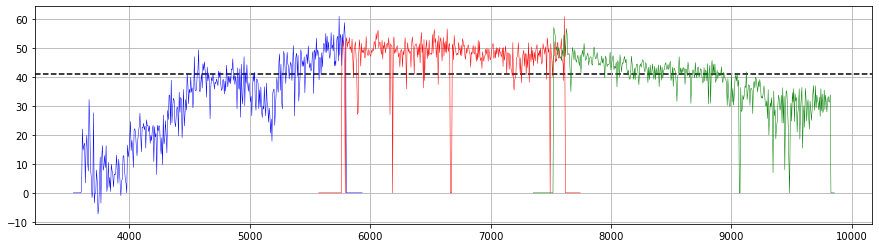

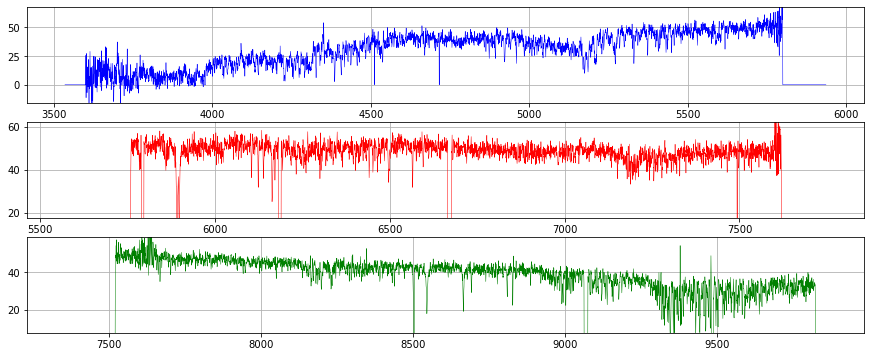

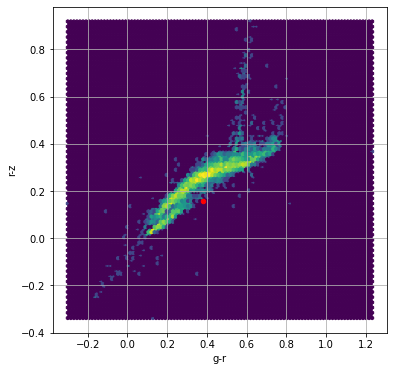

In [343]:
FIBER = mws_fibs[0] # 1780
d = summary(gather_data(NIGHT,EXPID,FIBER))

## Fit with rvspecfit

In [344]:
specdata, params, yfit = do_fit(d)

<Figure size 432x288 with 0 Axes>

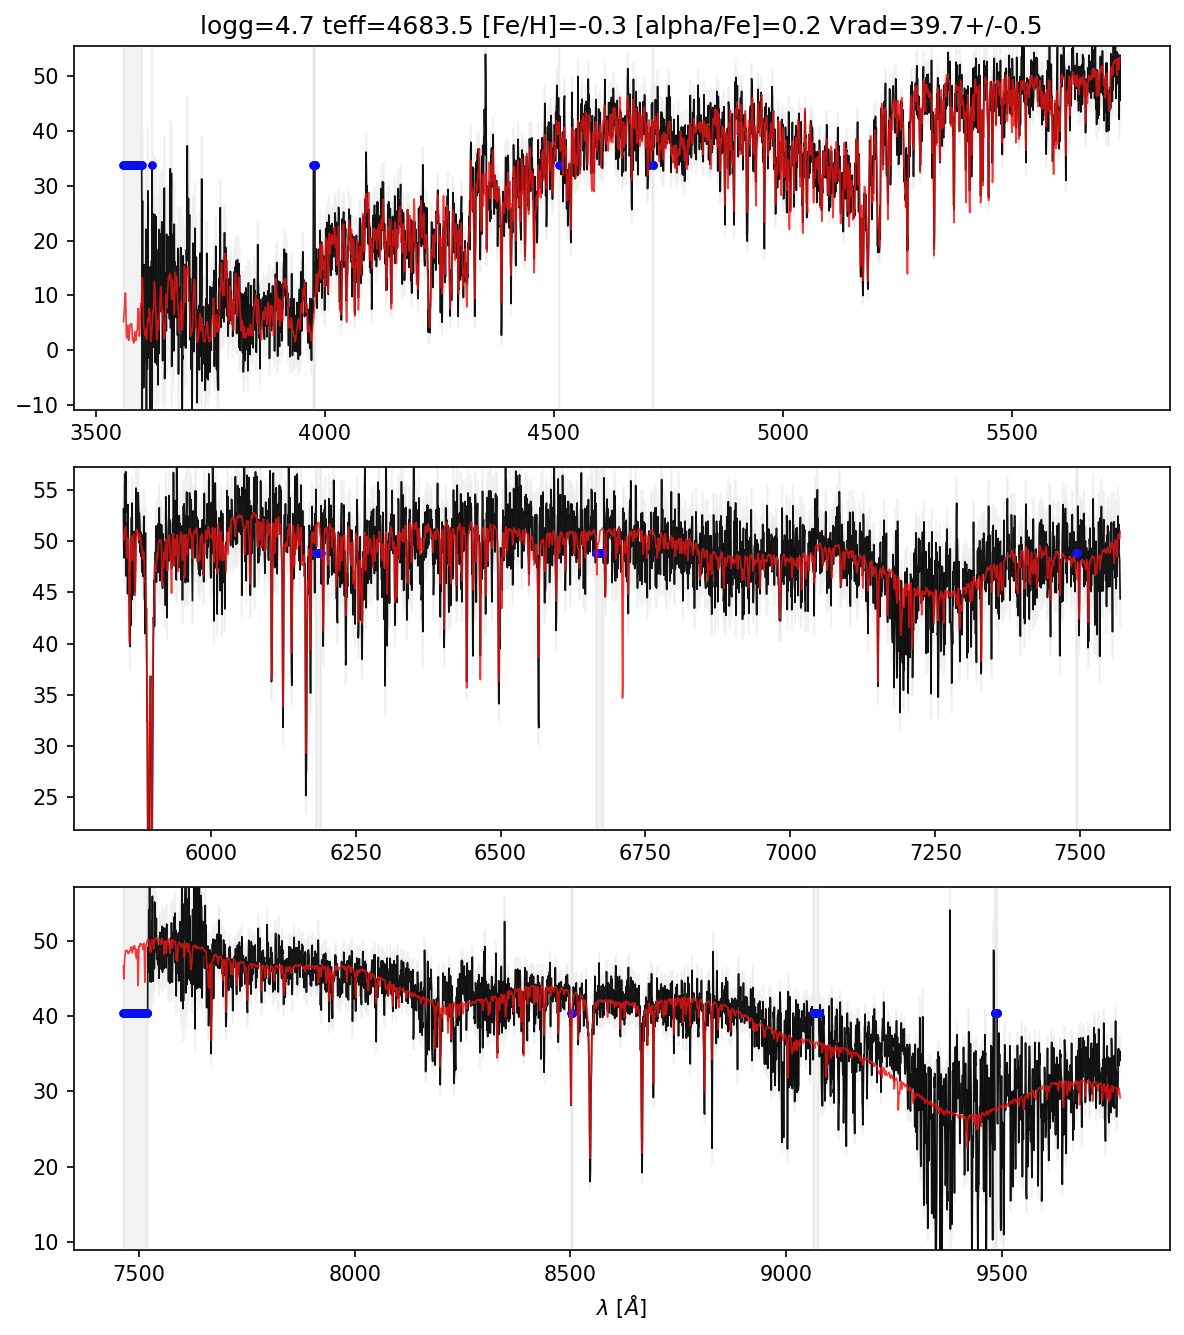

In [345]:
make_plot(specdata,params,yfit)